# Complexidade Topológica de Farber e modelagem matemática para planejamento de trajetórias

### Definição (TC)

A **complexidade topológica** de Farber de um espaço topológico $X$, denotada $\mathrm{TC}(X)$, é a **categoria de seção** da fibração dos caminhos
$$
\pi:X^I \longrightarrow X\times X,\qquad \pi(\gamma)=(\gamma(0),\gamma(1)),
$$
isto é, o menor $k\in\mathbb{N}$ tal que existe uma cobertura aberta $X\times X=\bigcup_{j=1}^k U_j$ e seções contínuas $s_j:U_j\to X^I$ com 
$$
\pi\circ s_j=\mathrm{id}_{U_j}.
$$

**Interpretação:** $\mathrm{TC}(X)$ é o número mínimo de **regras contínuas de planejamento de movimento** necessárias para levar qualquer par $(x_0,x_1)$ de posições a um caminho $\gamma$ de $x_0$ a $x_1$.


## No contexto de planejamento de caminhos em $\mathbb{R}^n$

### 1. $X$ convexo $\subset \mathbb{R}^n\Rightarrow\mathrm{TC}(X)=1$
Se $X$ é convexo, a regra única
$$
s(x_0,x_1)(t)=(1-t)\,x_0+t\,x_1
$$
é contínua e vale para todo $(x_0,x_1)\in X\times X$. Logo existe **uma** seção global da fibração $\pi$, e portanto $\mathrm{TC}(X)=1$.

### 2. $X\simeq S^1 \Rightarrow \mathrm{TC}(X)=2$
Resultado clássico: para a esfera $S^n$,
$$
\mathrm{TC}(S^n)=
\begin{cases}
2,& n\ \text{ímpar},\\
3,& n\ \text{par}.
\end{cases}
$$
Em particular, $n=1$ é ímpar, então $\mathrm{TC}(S^1)=2$.  
*Esboço da razão via cohomologia:* o **zero–divisor cup–length** de $H^*(S^1)$ vale $1$, logo $\mathrm{TC}(S^1)\ge 1+1=2$; por outro lado há um plano de movimento com duas regras (cobrindo pares não-antípodas e pares antípodas), concluindo $\mathrm{TC}(S^1)=2$.

### 3. $X\simeq \bigvee_{\alpha=1}^{N} S^1$ com $N\ge 2 \Rightarrow \mathrm{TC}(X)=3$
Para um grafo conexo $1$-dimensional:
$$
\mathrm{TC}(X)=
\begin{cases}
1, & X\ \text{contrátil (ex.: árvore/intervalo)},\\
2, & X\simeq S^1,\\
3, & \text{caso restante (p.ex., bouquet de \(\,N\ge 2\) círculos).}
\end{cases}
$$
*Esboço (limite inferior):* se $X\simeq \bigvee_{i=1}^N S^1$ com $N\ge 2$, então $H^1(X)$ tem posto $\ge 2$; tomando classes $a,b\in H^1(X)$, os zero–divisores $\bar a=a\otimes 1-1\otimes a$ e $\bar b=b\otimes 1-1\otimes b$ satisfazem $\bar a\smile \bar b\neq 0$, logo $\mathrm{zcl}(H^*(X))\ge 2$ e $\mathrm{TC}(X)\ge 3$.  
*Limite superior:* por dimensão, $\mathrm{TC}(X)\le 2\cdot \dim X+1=3$. Assim, $\mathrm{TC}(X)=3$.

---

> ### Resumo
>
>- Plano livre: $\mathrm{TC}(X)=1$.
>- Plano com um obstáculo: $\mathrm{TC}(X)=2$.
>- Plano com mais de um obstáculos: $\mathrm{TC}(X)=3$.
>
> **Nota:** esses valores de $\mathrm{TC}$ aparecem diretamente em problemas de planejamento de movimento: convexidade permite **uma regra global** (linha reta), o círculo exige **duas regras** por causa de antípodas, e um bouquet com $\ge 2$ ciclos exige **três regras**, refletindo a maior “complexidade topológica” (mais escolhas discretas de homotopia).

---


## (M0) Espaço sem obstáculos

Aqui consideramos que o espaço livre é homotopicamente trivial $(X \simeq *)$, ou seja, não há restrições globais além da dinâmica e dos limites de controle. O problema se reduz a encontrar uma trajetória dinâmica admissível entre o estado inicial e final.

$$
\begin{aligned}
\text{(M0)} \quad 
\min_{\{x_t,u_t\}_{t=0}^{T-1}} \quad & \sum_{t=0}^{T-1} |u_t|_2^2 \\
\text{sujeito a:} \quad
& x_{t+1} = A x_t + B u_t, \quad t=0,\dots,T-1, \\
& u_t\in U_{\text{lim}}, x_t\in X_{\text{lim}}, \quad t=0,\dots,T-1, \\
& x_0 = x_{\text{start}}, \quad x_T = x_{\text{goal}}.
\end{aligned}
$$

### Comentários

* **Função objetivo:** Minimiza o esforço de controle (ou energia total).
* **Dinâmica:** É um sistema linear discreto controlado.
* **Restrições de controle:** Mantêm o comando dentro de limites físicos.
* **Condições de contorno:** Fixam início e fim da trajetória.
* **Topologia:** Como não há obstáculos, o espaço é contrátil $(\pi_1(X)\cong 0$, $\operatorname{TC}(X)=1)$. Portanto, o problema é puramente convexo e sempre existe solução factível se o sistema for controlável.

Restricted license - for non-production use only - expires 2026-11-23


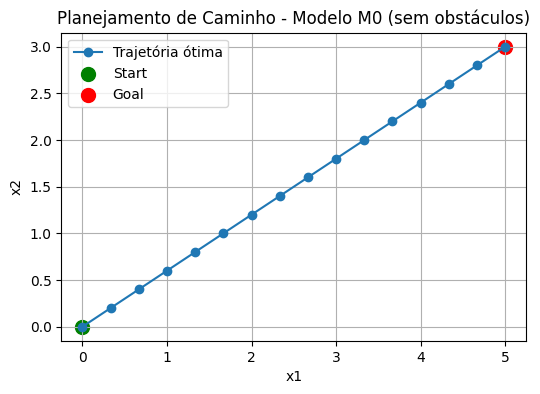

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB

# ---------------------
# PARÂMETROS DO PROBLEMA
# ---------------------
T = 15                   # horizonte de tempo
A = np.eye(2)            # dinâmica identidade
B = np.eye(2)            # controle direto (x_{t+1} = x_t + u_t)
u_min, u_max = -1.0, 1.0 # limites de controle
x_start = np.array([0.0, 0.0])
x_goal  = np.array([5.0, 3.0])

# ---------------------
# MODELO GUROBI
# ---------------------
mdl = Model("M0_PathPlanning")
mdl.setParam('OutputFlag', 0)  # silenciar log

# Variáveis
x = mdl.addVars(T+1, 2, lb=-GRB.INFINITY, name="x")  # estados
u = mdl.addVars(T, 2, lb=u_min, ub=u_max, name="u")  # controles

# Função objetivo: minimizar soma dos quadrados dos controles
mdl.setObjective(sum(u[t,0]*u[t,0] + u[t,1]*u[t,1] for t in range(T)), GRB.MINIMIZE)

# Restrições de dinâmica
for t in range(T):
    mdl.addConstr(x[t+1,0] == A[0,0]*x[t,0] + A[0,1]*x[t,1] + B[0,0]*u[t,0] + B[0,1]*u[t,1])
    mdl.addConstr(x[t+1,1] == A[1,0]*x[t,0] + A[1,1]*x[t,1] + B[1,0]*u[t,0] + B[1,1]*u[t,1])

# Condições de contorno
mdl.addConstr(x[0,0] == x_start[0])
mdl.addConstr(x[0,1] == x_start[1])
mdl.addConstr(x[T,0] == x_goal[0])
mdl.addConstr(x[T,1] == x_goal[1])

# ---------------------
# RESOLUÇÃO
# ---------------------
mdl.optimize()

# Extrair solução
x_sol = np.array([[x[t,0].X, x[t,1].X] for t in range(T+1)])
u_sol = np.array([[u[t,0].X, u[t,1].X] for t in range(T)])

# ---------------------
# PLOTAGEM
# ---------------------
plt.figure(figsize=(6,4))
plt.plot(x_sol[:,0], x_sol[:,1], 'o-', label="Trajetória ótima")
plt.scatter(x_start[0], x_start[1], c='green', s=100, label="Start")
plt.scatter(x_goal[0], x_goal[1], c='red', s=100, label="Goal")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Planejamento de Caminho - Modelo M0 (sem obstáculos)")
plt.legend()
plt.grid(True)
plt.show()


## (M1) Um obstáculo circular

Considere um obstáculo **disco** $\mathcal{O}=\{z\in\mathbb{R}^2:|z-c|_2\le r\}$ com centro $c\in\mathbb{R}^2$ e raio $r\in\mathbb{R}_+$.
Imponha que **cada segmento** $[x_t,x_{t+1}]$ fique a pelo menos $r$ do centro $c$.
Uma maneira contínua/convexa é garantir que o **ponto mais próximo** do segmento ao centro tenha distância $\ge r$.
Introduza variáveis auxiliares $\lambda_t\in[0,1]$ e $y_t$ como o ponto do segmento mais próximo de $c$:

$$
\begin{aligned}
\min_{\substack{\{x_t,u_t\}\\ \{\lambda_t,y_t\}}}\quad
& \sum_{t=0}^{T-1}|u_t|_2^2 \\
\text{s.a.}\quad
& x_{t+1}=Ax_t+Bu_t,\quad t=0,\dots,T-1,\\
& u_t\in U_{\text{lim}}, x_t\in X_{\text{lim}},\quad t=0,\dots,T-1,\\
& x_0=x_{\text{start}},\quad x_T=x_{\text{goal}},\\
& y_t = (1-\lambda_t) x_t + \lambda_t x_{t+1},\quad t=0,\dots,T-1,\\
& 0\le \lambda_t \le 1,\quad t=0,\dots,T-1,\\
& |y_t - c|_2 \ge r + \delta,\quad t=0,\dots,T-1.
\end{aligned}
$$

onde $\delta$ corresponde à uma margem conservadora.

### Comentários

* **Função objetivo:** Minimiza o esforço de controle (ou energia total).
* **Dinâmica:** É um sistema linear discreto controlado.
* **Condições de contorno:** Fixam início e fim da trajetória.
* **Topologia:** Como há um obstáculo, o espaço tem o mesmo tipo de homotopia que $S^1$ $(\pi_1(S^1)\cong\mathbb{Z}$, $\operatorname{TC}(X)=2)$.
* **Restrições de controle:**:
    * As últimas três linhas dizem: **escolha o ponto do segmento** $[x_t,x_{t+1}]$ mais “crítico” (via $\lambda_t$) e **afaste-o** do centro ao menos $r$.
    * As restrições são **convexas** (SOCP) exceto pela escolha “exata” do ponto mais próximo. Na prática, esse modelo funciona como **relaxação segura**: se $|y_t-c|\ge r$ para algum $y_t$ **livre** em $[x_t,x_{t+1}]$, então o segmento inteiro está fora do disco *não necessariamente*; Conforme pode ser visto nas implementações a seguir, na prática modelamos os pontos fora do raio, e isso não gatante que o seguimento não corta o obstáculo.


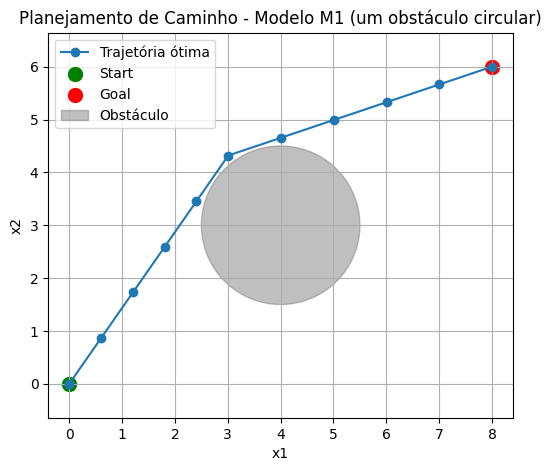

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, QuadExpr

# ---------------------
# PARÂMETROS
# ---------------------
T = 10                     # horizonte
u_min, u_max = -1.0, 1.0   # limites de controle
x_start = np.array([0.0, 0.0])
x_goal  = np.array([8.0, 6.0])

# Obstáculo circular
c = np.array([4.0, 3.0])   # centro
r = 1.5                    # raio
delta = 0.15
R = r+delta

# ---------------------
# MODELO GUROBI
# ---------------------
mdl = Model("M1_PathPlanning")
mdl.setParam('OutputFlag', 0)

# Variáveis
x = mdl.addVars(T+1, 2, lb=-GRB.INFINITY, name="x")   # estados
u = mdl.addVars(T, 2, lb=u_min, ub=u_max, name="u")   # controles

# Objetivo: minimizar energia de controle
mdl.setObjective(sum(u[t,0]*u[t,0] + u[t,1]*u[t,1] for t in range(T)), GRB.MINIMIZE)

# Dinâmica: x_{t+1} = x_t + u_t
for t in range(T):
    mdl.addConstr(x[t+1,0] == x[t,0] + u[t,0])
    mdl.addConstr(x[t+1,1] == x[t,1] + u[t,1])

# Condições de contorno
mdl.addConstr(x[0,0] == x_start[0])
mdl.addConstr(x[0,1] == x_start[1])
mdl.addConstr(x[T,0] == x_goal[0])
mdl.addConstr(x[T,1] == x_goal[1])

# Restrição de não colisão (cada ponto fora do círculo)
for t in range(T+1):
    expr = QuadExpr()
    expr.add((x[t,0] - c[0]) * (x[t,0] - c[0]))
    expr.add((x[t,1] - c[1]) * (x[t,1] - c[1]))
    mdl.addQConstr(expr >= R*R)

# ---------------------
# RESOLUÇÃO
# ---------------------
mdl.optimize()

# Extrair solução
x_sol = np.array([[x[t,0].X, x[t,1].X] for t in range(T+1)])

# ---------------------
# PLOTAGEM
# ---------------------
theta = np.linspace(0, 2*np.pi, 200)
circle_x = c[0] + r*np.cos(theta)
circle_y = c[1] + r*np.sin(theta)

plt.figure(figsize=(6,5))
plt.plot(x_sol[:,0], x_sol[:,1], 'o-', label="Trajetória ótima")
plt.scatter(x_start[0], x_start[1], c='green', s=100, label="Start")
plt.scatter(x_goal[0], x_goal[1], c='red', s=100, label="Goal")
plt.fill(circle_x, circle_y, color='gray', alpha=0.5, label="Obstáculo")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Planejamento de Caminho - Modelo M1 (um obstáculo circular)")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()


## (M2) $N$ obstáculos circulares — **segmento seguro por disjunções**

Considere $N$ **obstáculos circulares** $\mathcal O_i=\{z\in\mathbb R^2:\|z-c_i\|_2\le r_i\}$ com centros $c_i=(c_{i,1},c_{i,2})$ e raios $r_i>0$.
Impomos ficar **fora** da **caixa alinhada aos eixos** que circunscreve o disco inflado $r_i+\varepsilon$.
Para cada obstáculo $i$ e instante $t$, escolhe-se **ao menos uma** entre quatro alternativas (esquerda/direita/abaixo/acima) via binárias e Big-$M$.

Fixe uma **margem** $\varepsilon>0$ e, para cada disco inflado $r_i+\varepsilon$.

**Modelo:**
$$
\begin{aligned}
\min_{\{x_t,u_t,b\}} \quad & \sum_{t=0}^{T-1}\|u_t\|_2^2 \\[2mm]
\text{s.a.}\quad
& x_{t+1}=x_t+u_t,\qquad t=0,\dots,T-1,\\
& u_{\min}\le u_t^{(j)}\le u_{\max},\ \ j=1,2,\ \ t=0,\dots,T-1,\\
& x_0=x_{\text{start}},\quad x_T=x_{\text{goal}},\\[2mm]
& \forall i=1,\dots,N,\ \ t=0,\dots,T:\\
& \qquad b^{L}_{i,t}+b^{R}_{i,t}+b^{B}_{i,t}+b^{T}_{i,t}\ \ge\ 1, \qquad\text{(escolhe um “lado”)}\\
& \qquad x_t^{(1)} \le c_{i,1}-(r_i+\varepsilon)\ +\ M(1-b^{L}_{i,t}),\\
& \qquad x_t^{(1)} \ge c_{i,1}+(r_i+\varepsilon)\ -\ M(1-b^{R}_{i,t}),\\
& \qquad x_t^{(2)} \le c_{i,2}-(r_i+\varepsilon)\ +\ M(1-b^{B}_{i,t}),\\
& \qquad x_t^{(2)} \ge c_{i,2}+(r_i+\varepsilon)\ -\ M(1-b^{T}_{i,t}),\\
& \qquad b^{L}_{i,t},b^{R}_{i,t},b^{B}_{i,t},b^{T}_{i,t}\in\{0,1\}.
\end{aligned}
$$

### Comentários

* **Função objetivo:** Minimiza o esforço de controle (ou energia total).
* **Dinâmica:** É um sistema linear discreto controlado.
* **Condições de contorno:** Fixam início e fim da trajetória.
* **Topologia:** Como há vários obstáculos, o espaço tem o mesmo tipo de homotopia que $\vee_{\alpha=1}^N S^1$ $(\pi_1(\vee_{\alpha=1}^N S^1)\cong\mathop{*}_{\alpha=1}^{N}\mathbb{Z}$, $\operatorname{TC}(X)=3)$.
* **Restrições de controle:**:
    * As últimas três linhas dizem: **escolha o ponto do segmento** $[x_t,x_{t+1}]$ mais “crítico” (via $\lambda_t$) e **afaste-o** do centro ao menos $r$.
    * Assim como M1 este modelo garante que os extremos dos seguimentos estajam fora dos obstáculos, para obter bons resultados precisamos ajustar $T$ e $\varepsilon$ conforme a quantidade e tamanho dos obstáculos.


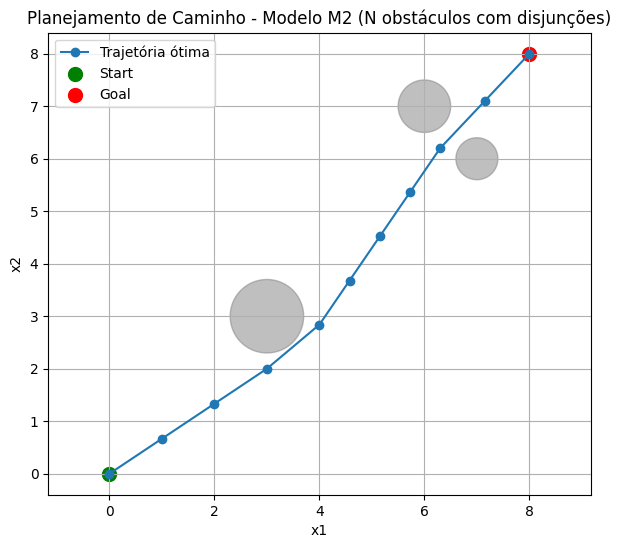

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB

# ---------------------
# PARÂMETROS
# ---------------------
T = 10
u_min, u_max = -1.0, 1.0
x_start = np.array([0.0, 0.0])
x_goal  = np.array([8.0, 8.0])

# Lista de obstáculos (círculos)
obstacles = [
    (np.array([3.0, 3.0]), 0.7),
    (np.array([7.0, 6.0]), 0.4),
    (np.array([6.0, 7.0]), 0.5),
]

epsilon = 0.3
M = 1000.0

# ---------------------
# MODELO GUROBI
# ---------------------
mdl = Model("M2_PathPlanning")
mdl.setParam('OutputFlag', 0)

# Variáveis
x = mdl.addVars(T+1, 2, lb=-GRB.INFINITY, name="x")
u = mdl.addVars(T, 2, lb=u_min, ub=u_max, name="u")

# Binárias: para cada obstáculo i, tempo t e direção (L,R,B,T)
b = {}
for i in range(len(obstacles)):
    for t in range(T+1):
        for d in ["L", "R", "B", "T"]:
            b[i,t,d] = mdl.addVar(vtype=GRB.BINARY, name=f"b_{i}_{t}_{d}")

mdl.update()

# Objetivo: minimizar energia de controle
mdl.setObjective(sum(u[t,0]*u[t,0] + u[t,1]*u[t,1] for t in range(T)), GRB.MINIMIZE)

# Dinâmica
for t in range(T):
    mdl.addConstr(x[t+1,0] == x[t,0] + u[t,0])
    mdl.addConstr(x[t+1,1] == x[t,1] + u[t,1])

# Condições de contorno
mdl.addConstr(x[0,0] == x_start[0])
mdl.addConstr(x[0,1] == x_start[1])
mdl.addConstr(x[T,0] == x_goal[0])
mdl.addConstr(x[T,1] == x_goal[1])

# Restrições de não colisão disjuntivas
for i,(c,r) in enumerate(obstacles):
    for t in range(T+1):
        # Cada ponto deve satisfazer ao menos uma das 4 opções
        mdl.addConstr(b[i,t,"L"] + b[i,t,"R"] + b[i,t,"B"] + b[i,t,"T"] >= 1)

        # Esquerda
        mdl.addConstr(x[t,0] <= c[0] - r - epsilon + M*(1-b[i,t,"L"]))
        # Direita
        mdl.addConstr(x[t,0] >= c[0] + r + epsilon - M*(1-b[i,t,"R"]))
        # Abaixo
        mdl.addConstr(x[t,1] <= c[1] - r - epsilon + M*(1-b[i,t,"B"]))
        # Acima
        mdl.addConstr(x[t,1] >= c[1] + r + epsilon - M*(1-b[i,t,"T"]))

# ---------------------
# RESOLUÇÃO
# ---------------------
mdl.optimize()

# Extrair solução
x_sol = np.array([[x[t,0].X, x[t,1].X] for t in range(T+1)])

# ---------------------
# PLOTAGEM
# ---------------------
plt.figure(figsize=(7,6))
plt.plot(x_sol[:,0], x_sol[:,1], 'o-', label="Trajetória ótima")
plt.scatter(x_start[0], x_start[1], c='green', s=100, label="Start")
plt.scatter(x_goal[0], x_goal[1], c='red', s=100, label="Goal")

theta = np.linspace(0,2*np.pi,200)
for (c,r) in obstacles:
    plt.fill(c[0] + r*np.cos(theta), c[1] + r*np.sin(theta), color='gray', alpha=0.5)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Planejamento de Caminho - Modelo M2 (N obstáculos com disjunções)")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()
